In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import gensim
import gensim.downloader as api
import whisper
import re
import os
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from gensim.models import KeyedVectors
from nltk.stem import WordNetLemmatizer
import gensim.downloader as api
from sklearn.neighbors import NearestNeighbors
from moviepy.editor import VideoFileClip
from IPython.display import display, YouTubeVideo
import ipywidgets as widgets

##Summarization model specific library:
from transformers import pipeline, set_seed
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
from datasets import load_dataset, load_metric


glove_model = api.load('glove-wiki-gigaword-50')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

/home/ubuntu/.local/lib/python3.8/site-packages/whisper/timing.py:58: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def backtrace(trace: np.ndarray):
[nltk_data] Downloading package punkt to /home/ubuntu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/ubuntu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ubuntu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/ubuntu/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [2]:
!conda info | grep 'active env'
#!jupyter nbextension enable --py widgetsnbextension

     active environment : pytorch
    active env location : /home/ubuntu/miniconda3/envs/pytorch


In [3]:
class Search:
    
    def __init__(self, video_to_text_model, video_id, file_path, fname):
        self.video_to_text_model=video_to_text_model
        self.video_id=video_id
        self.file_path=file_path
        self.fname=fname
    
    #1. Extracts text from videos:
    def video_to_text(self):
        model = whisper.load_model(self.video_to_text_model)
        result = model.transcribe(self.file_path+self.video_id+".mp4")
        return result
    
    #2. write the extracted files to data lake: S3
    def write_video_text_results(self, dict_name):
        self.dict_name = dict_name
        # Convert dictionary to JSON string
        json_string = json.dumps(self.dict_name)
        # Write JSON string to file
        with open(self.file_path+self.fname, "w") as f:
            f.write(json_string)
            
        return None
    
    #3. load extracted text files:
    def load_text_extract_file(self, fname):
        self.fname = fname
        with open(self.file_path+self.fname, "r") as f:
            json_string = f.read()

        # Convert JSON string to dictionary
        my_dict = json.loads(json_string)
        return my_dict
    
    #4. extracts just text and append in rows one by one:
    def append_text_from_json(self, subtitle):
        self.rows = []
        for item in subtitle['segments']:
            text = item.get('text', '')
            self.rows.append(text)
        return self.rows

    #5. Text cleaning:
    def preprocess_text(self, df, text_column, new_text):
        self.df = df.copy()
        # Remove punctuations
        #self.df[new_text] = self.df[text_column]
        #translator = str.maketrans('-', ' ', string.punctuation)
        #self.df[new_text] = self.df[text_column].apply(lambda x: x.translate(translator))
        
        self.df[new_text] = self.df[text_column].apply(lambda x: re.sub('[^a-zA-Z]', ' ', x))

        # Convert to lowercase
        self.df[new_text] = self.df[new_text].apply(lambda x: x.lower())

        # Tokenize words
        self.df[new_text] = self.df[new_text].apply(lambda x: word_tokenize(x))

        # Remove stop words
        stop_words = set(stopwords.words('english'))
        self.df[new_text] = self.df[new_text].apply(lambda x: [word for word in x if not word in stop_words])

        # Lemmatize words
        # lemmatizer = WordNetLemmatizer()
        # self.df[new_text] = self.df[new_text].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

        # Join words back to form text
        self.df[new_text] = self.df[new_text].apply(lambda x: '  '.join(x))

        return self.df
    
    #6. Clean the target text:
    def preprocess_single_sentence(self, sentence):

        # Remove punctuations and digits
        sentence = re.sub('[^a-zA-Z]', ' ', sentence)

        # Convert to lowercase
        sentence = sentence.lower()

        # Tokenize words
        sentence = word_tokenize(sentence)

        # Remove stop words
        stop_words = set(stopwords.words('english'))
        sentence = [word for word in sentence if not word in stop_words]

        # Join words back to form text
        sentence = ' '.join(sentence)

        return sentence
    
    #7. Creates embeddings:
    def get_embedding(self, sentence):
        tokens = sentence.split()
        embedding = []
        for token in tokens:
            try:
                embedding.append(glove_model[token])
            except KeyError:
                # If token is not found in the GloVe model, skip it
                pass
        if len(embedding) == 0:
            # If no tokens were found in the GloVe model, return a vector of zeros
            embedding = [np.zeros(50)]
        return np.mean(embedding, axis=0)
    
    #8. Check if the video text already exist ? If not exist then extract texts from videos:
    def check_file(self, fname):
        self.fname = fname
        if os.path.exists(self.file_path+self.fname):
            print("The text file already exist for the session id:",self.video_id)
            return 1
        else:
            return 0
    #9. Saving the embeddings file for the future use.
    def save_embedding_file(self, df, embedName):
        self.df = df
        self.embedName = embedName
        
        np.save(self.file_path+self.embedName, self.df)
        return None
    
    #10. Loading the embeddings file.
    def load_embedding_file(self, embedName):
        self.embedName = embedName
        cols = ['sentence', 'clean_sentence', 'embeddings']
        
        load_embed_data = np.load(self.file_path+self.embedName, allow_pickle=True)
        df = pd.DataFrame(load_embed_data, columns = cols)
        return df
    
    #11. Read the search keywords from students:
    def read_input_from_keywords(self, counter=0):
        target_text = input("Enter your keywords here: ").lower()
        counter += 1
        if target_text=="" and counter<= 2:
            print("You did not enter anything please try again!")
            target_text = self.read_input_from_keywords(counter)
        else:
            print("Your entered keywords are:", target_text)
        return target_text
    
    #12. Define a function to update the video player based on the start time input
    def update_video(self, start_time):
        
        self.start_time = start_time
        display(YouTubeVideo(self.video_id, start=int(self.start_time), autoplay = True))
        
    #13. Refactorizing the followings:
        #a. Appeding text from preprocessing:
        #b. converting to list to df
        #c. Text cleanup
        #d. Creates embeddings to the cleaned text
        #e. Save the embeddings file
    
    def preparing_data_for_model(self, subtitle, embedding_file):
        self.subtitle = subtitle
        self.embedding_file = embedding_file
        
        # Appending texts for preprocessing:
        subtitle_text_list = self.append_text_from_json(self.subtitle)
        
        # Converting list to df:
        text_data_df = pd.DataFrame(subtitle_text_list, columns=['sentence'])
        
        # Text cleanup: For now just keeping the words: ^^^ Needs to revisit this:^^^
        cleaned_df = self.preprocess_text(text_data_df, 'sentence', 'clean_sentence')
        
        # Creates embeddings to the cleaned text: ^^^ Using word embeddings needs to think about hybrid(word+char)^^^
        cleaned_df['embeddings'] = cleaned_df['clean_sentence'].apply(self.get_embedding)
        
        # Save the embeddings file:
        self.save_embedding_file(cleaned_df, self.embedding_file)
        
        return cleaned_df
        
        

# How does it works:
## Accept & process target text:
    1. Accept keywords or topics from students.
    2. Clean the target text.
    3. Create embeddings of target text.

## search model:
    1. Check if embeddings for given video_id exists:
        I. If no embeddings is available:
            A. Check whether text file exist for the given video_id. If text file doesn't exist:
                i. Call text to video model and extracts videos to text.
               ii. Save the extracted texts to data lake: S3
              iii. clean and preprocess the text sentences.
               iV. Create embeddings with help of effiient embeddings model.
                V. Save the embedded file.
            B. If text file does exist:
                i. Load the extracted text file.
                   a. check for the embeddings, If it exists:
                       - Load the embeddings file.
                   b. If it doesn't exist:
                       - clean and preprocess the text sentences.
                       - Create embeddings with help of effiient embeddings model.
                       - Save the embedded file.
                       
                  
       II. If embeddings file exist:
           A. Load the extracted text file
           B. Load the embeddings file.
    2. Call the search model and use its output to idenify the the most similar keywords.
    3. Extract the corresponding indeces timestamps from the extracted text.
    4. Update the video for the matching timestamps.
   
                

In [4]:
def text_search_within_video(video_id, target_text):
    
    ## Adjust them based on the requirements:
    model_name="medium.en"    #['mdedium-en', 'large', 'large-v2', 'small-en', 'tiny-en']
    video_path="/home/ubuntu/New_program/text_search_video/videos/"
    fname     = video_id+".json"
    embedding_file = video_id+"_embeddings.npy"
    
    ##Declare class:
    search = Search(model_name, video_id, video_path, fname)
    text_file_exist = search.check_file(fname)
    if text_file_exist==0: # The extracted file doesn't exist:
        print("The text doesn't exist for video_id:", video_id)
        print("The text extraction is in process....")

        ## Extract texts from video and save in the repository:
        subtitle = search.video_to_text()
        search.write_video_text_results(subtitle)

        ## Prepare text data for the model input:
        cleaned_df=search.preparing_data_for_model(subtitle, embedding_file)
        embeddings_vector=cleaned_df['embeddings']
        embeddings_array=np.stack(embeddings_vector)

        ## Accept input from students and clean it:
        #target_text = search.read_input_from_keywords()
        new_target_text = search.preprocess_single_sentence(target_text)
        target_vector = search.get_embedding(new_target_text)

        ##Model:
        knn_model = NearestNeighbors(n_neighbors=3, metric='cosine').fit(embeddings_array)
        distances, indices = knn_model.kneighbors(target_vector.reshape(1, -1))

        index = indices[0][0]
        start_time = subtitle['segments'][index]['start']
        if start_time >= 0:
            time_widget = widgets.FloatText(value=start_time, description='Start Time (sec):') # Create a widget for the start time input
            search.update_video(start_time)                                                    # Call the update_video function with the initial start time
            button = widgets.Button(description='Update Video')                                # Create a button to trigger the video player update

        else:
            None

    # When file exists:
    elif text_file_exist==1:
        ## Load subtitle file:
        subtitle = search.load_text_extract_file(fname)
        ## Check for the embeddings file:
        embed_file_exist = search.check_file(embedding_file)
        if embed_file_exist==0:

            print("There is not embeddings found hence creating the embeddings...")
            ## Prepare text data for the model input:
            cleaned_df=search.preparing_data_for_model(subtitle, embedding_file)
            embeddings_vector=cleaned_df['embeddings']
            embeddings_array=np.stack(embeddings_vector)

            ## Accept input from students and clean it:
            #target_text = search.read_input_from_keywords()
            new_target_text = search.preprocess_single_sentence(target_text)
            target_vector = search.get_embedding(new_target_text)

            ##Model:
            knn_model = NearestNeighbors(n_neighbors=3, metric='cosine').fit(embeddings_array)
            distances, indices = knn_model.kneighbors(target_vector.reshape(1, -1))

            index = indices[0][0]
            start_time = subtitle['segments'][index]['start']
            if start_time >= 0:
                time_widget = widgets.FloatText(value=start_time, description='Start Time (sec):') # Create a widget for the start time input
                search.update_video(start_time)                                                    # Call the update_video function with the initial start time
                button = widgets.Button(description='Update Video')                                # Create a button to trigger the video player update

            else:
                None

        # When embeddings exist then load it:
        elif embed_file_exist==1:
            cleaned_df=search.load_embedding_file(embedding_file)
            embeddings_vector=cleaned_df['embeddings']
            embeddings_array=np.stack(embeddings_vector)
#             print(embeddings_array)
            print(cleaned_df.shape)
            ## Accept input from students and clean it:
            #target_text = search.read_input_from_keywords()
            new_target_text = search.preprocess_single_sentence(target_text)
            target_vector = search.get_embedding(new_target_text)
            print(target_vector.reshape(1, -1).shape)
            ##Model:
            knn_model = NearestNeighbors(n_neighbors=3, metric='cosine').fit(embeddings_array)
            distances, indices = knn_model.kneighbors(target_vector.reshape(1, -1))


            index = indices[0][0]
            start_time = subtitle['segments'][index]['start']
            if start_time >= 0:
                time_widget = widgets.FloatText(value=start_time, description='Start Time (sec):') # Create a widget for the start time input
                search.update_video(start_time)                                                    # Call the update_video function with the initial start time
                button = widgets.Button(description='Update Video')                                # Create a button to trigger the video player update

            else:
                None

The text file already exist for the session id: OgbBtDCNELA
The text file already exist for the session id: OgbBtDCNELA
(217, 3)
(1, 50)


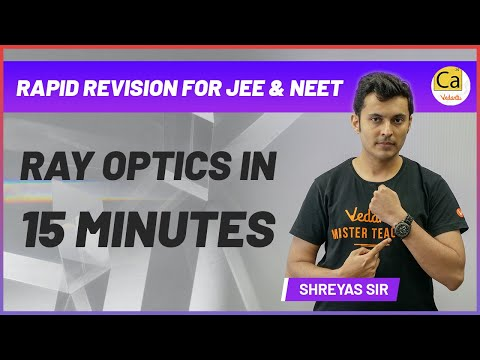

In [5]:
video_id="OgbBtDCNELA"
target_text="What is focal lenght?"
text_search_within_video(video_id, target_text)

In [6]:
#session_ids=['kh02NmGZPyk', 'OgbBtDCNELA']

0
The text file already exist for the session id: OgbBtDCNELA
The text file already exist for the session id: OgbBtDCNELA
(217, 3)
(1, 50)


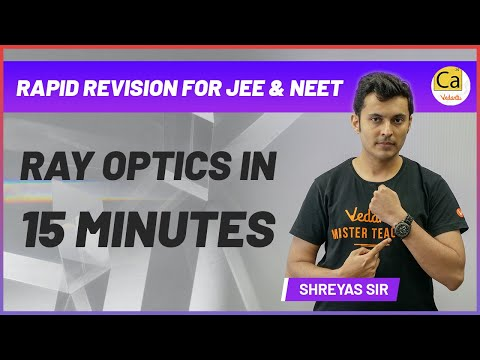

1
The text file already exist for the session id: kh02NmGZPyk
The text file already exist for the session id: kh02NmGZPyk
(39, 3)
(1, 50)


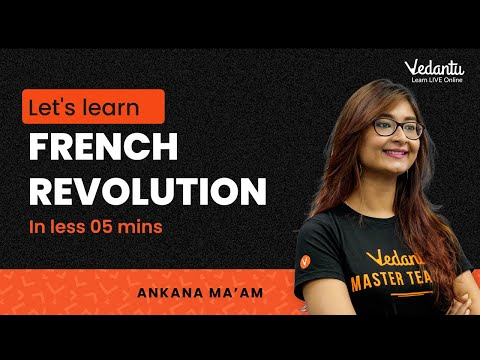

2
The text file already exist for the session id: AeL1K2K5tP8
The text file already exist for the session id: AeL1K2K5tP8
(333, 3)
(1, 50)


In [7]:
target_text="What is lens formula?"
session_ids=['OgbBtDCNELA', 'kh02NmGZPyk', 'AeL1K2K5tP8']
for id_ in range(len(session_ids)):
    print(id_)
    video_id = session_ids[id_]
    text_search_within_video(video_id, target_text)

### Create summarization from subtitle:

In [8]:
dataset = load_dataset("cnn_dailymail", version="3.0.0")

print(f"Features in cnn_dailymail : {dataset['train'].column_names}")

Found cached dataset cnn_dailymail (/home/ubuntu/.cache/huggingface/datasets/cnn_dailymail/default/3.0.0/1b3c71476f6d152c31c1730e83ccb08bcf23e348233f4fcc11e182248e6bf7de)


  0%|          | 0/3 [00:00<?, ?it/s]

Features in cnn_dailymail : ['article', 'highlights', 'id']


In [9]:
sample = dataset["train"][1]
print(f"""
Article (excerpt of 500 characters, total length: {len(sample["article"])}):
""")
print(sample["article"][:500])
print(f'\nSummary (length: {len(sample["highlights"])}):')
print(sample["highlights"])


Article (excerpt of 500 characters, total length: 4051):

Editor's note: In our Behind the Scenes series, CNN correspondents share their experiences in covering news and analyze the stories behind the events. Here, Soledad O'Brien takes users inside a jail where many of the inmates are mentally ill. An inmate housed on the "forgotten floor," where many mentally ill inmates are housed in Miami before trial. MIAMI, Florida (CNN) -- The ninth floor of the Miami-Dade pretrial detention facility is dubbed the "forgotten floor." Here, inmates with the most s

Summary (length: 281):
Mentally ill inmates in Miami are housed on the "forgotten floor"
Judge Steven Leifman says most are there as a result of "avoidable felonies"
While CNN tours facility, patient shouts: "I am the son of the president"
Leifman says the system is unjust and he's fighting for change .


In [10]:
sample_text = dataset["train"][1]["article"][:1000]

# We'll collect the generated summaries of each model in a dictionary
summaries = {}

In [11]:
sample_text

'Editor\'s note: In our Behind the Scenes series, CNN correspondents share their experiences in covering news and analyze the stories behind the events. Here, Soledad O\'Brien takes users inside a jail where many of the inmates are mentally ill. An inmate housed on the "forgotten floor," where many mentally ill inmates are housed in Miami before trial. MIAMI, Florida (CNN) -- The ninth floor of the Miami-Dade pretrial detention facility is dubbed the "forgotten floor." Here, inmates with the most severe mental illnesses are incarcerated until they\'re ready to appear in court. Most often, they face drug charges or charges of assaulting an officer --charges that Judge Steven Leifman says are usually "avoidable felonies." He says the arrests often result from confrontations with police. Mentally ill people often won\'t do what they\'re told when police arrive on the scene -- confrontation seems to exacerbate their illness and they become more paranoid, delusional, and less likely to foll

In [12]:
def baseline_summary_three_sent(text):
    return "\n".join(sent_tokenize(text)[:3])

In [13]:
summaries['baseline'] = baseline_summary_three_sent(sample_text)

summaries['baseline']

'Editor\'s note: In our Behind the Scenes series, CNN correspondents share their experiences in covering news and analyze the stories behind the events.\nHere, Soledad O\'Brien takes users inside a jail where many of the inmates are mentally ill. An inmate housed on the "forgotten floor," where many mentally ill inmates are housed in Miami before trial.\nMIAMI, Florida (CNN) -- The ninth floor of the Miami-Dade pretrial detention facility is dubbed the "forgotten floor."'

In [14]:
pipe = pipeline('summarization', model="google/pegasus-cnn_dailymail"  )

pipe_out = pipe(sample_text)

In [15]:
pipe_out

[{'summary_text': 'Mentally ill inmates are housed on the "forgotten floor" of a Miami jail .<n>Judge Steven Leifman says the charges are usually "avoidable felonies"<n>He says the arrests often result from confrontations with police .<n>Mentally ill people often won\'t do what they\'re told when police arrive on the scene .'}]

In [16]:
model_name="small.en"    #['mdedium-en', 'large', 'large-v2', 'small-en', 'tiny-en']
video_path="/home/ubuntu/New_program/text_search_video/videos/"
fname     = video_id+".json"
embedding_file = video_id+"_embeddings.npy"

In [17]:
video_id="OgbBtDCNELA"
fname=video_id+'.json'
search = Search(model_name, video_id, video_path, fname)

In [18]:
subtitle=search.load_text_extract_file(fname)

In [19]:
subtitle_text = subtitle['text'][500:1000]

In [20]:
len(subtitle_text)

500

In [21]:
pipe_out = pipe(subtitle_text)

Your max_length is set to 128, but you input_length is only 109. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=54)


In [22]:
pipe_out[0]['summary_text']

"A real image is formed when the rays converge at a particular point like it's shown over here .<n>A virtual image is formed when the rays appear to diverge from a particular point like the one shown over here ."

In [23]:
pipe_out[0]['summary_text']

"A real image is formed when the rays converge at a particular point like it's shown over here .<n>A virtual image is formed when the rays appear to diverge from a particular point like the one shown over here ."

In [24]:
def summarize_subtitle(subtitle, pipe):
    summarized_text = []
    step = 500
    for i in range(0, len(subtitle['text']), step):
        text_chunk = subtitle['text'][i:i+step]
        model_output = pipe(text_chunk)
        summarized_text.append(model_output)
    print("Summary:")
    for item in summarized_text:
        print(f"- {item}")

In [ ]:
%%time
pipe = pipeline('summarization', model="google/pegasus-cnn_dailymail")
subtitle=search.load_text_extract_file(fname)
summarize_subtitle(subtitle, pipe)

Your max_length is set to 128, but you input_length is only 106. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=53)
Your max_length is set to 128, but you input_length is only 109. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=54)
Your max_length is set to 128, but you input_length is only 113. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=56)
Your max_length is set to 128, but you input_length is only 106. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=53)
Your max_length is set to 128, but you input_length is only 111. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=55)
Your max_length is set to 128, but you input_length is only 109. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=54)
Your max_length is set to 128, but you input_length is only 101. You might c